# Generating Human Faces Using DCGAN

UofT - School of Continuing Studies

Deep Learning 2021

Danushyan Shandrasekaram

**Project Overview**

The goal of this project was to understand and build a Generative Adversarial Network to produce artificial faces that were comparable to faces from real photos. A secondary goal was to see which model parameters such as number of layers, size of noise vectors, batch size, etc. would produce the best results.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/data/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

**Data Aquisition and Pre-processing**

To train the network, the CelebA dataset (over 10000 photos of celebrities) acquired from Kaggle was used. This dataset is great for training and testing models for face detection, particularly for recognizing facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large number of images and rich annotations. 

Most images in the dataset were of size 208 x 178. For the model to be trained properly, the images were resized to 128 x 128 while making sure that important features from the photos were not excluded. The images were then stored in an images array ready to be used for training by the model.

Link to Kaggle Dataset<br>
https://www.kaggle.com/jessicali9530/celeba-dataset


In [2]:
PIC_DIR = f'./data/input/celeba-dataset/img_align_celeba/img_align_celeba/'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

# resize image dimensions
WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Img.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(pic))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 238.07it/s]


In [3]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


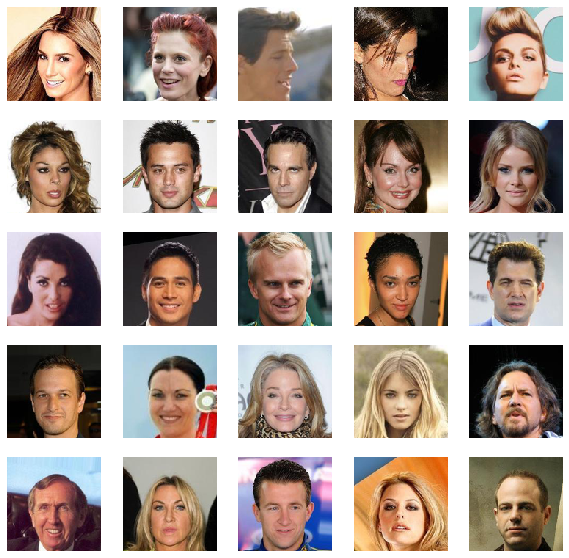

In [4]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

**Creating the Generator**

The generator network designed here consists of 8 convolution layers. Each convolution layer preforms convolution and then performs batch normalization and a leaky ReLu as well. Finally the ‘tanh’ activation function is used to produce the output. The generator has no loss function or any optimization algorithm. It uses transpose convolution layers to upsample the low-resolution dense layer from the latent space to build higher resolution images. 

A noise vector, LATENT_DIM = 32 was used to get the GAN to produce a wide variety of data, sampling from different places in the target distribution. From research, experiments were done suggesting that the distribution of the noise doesn’t matter too much.

Batch normalization was used to standardize the activations from prior layers to have zero mean and unit variance. From past projects with Neural Networks, batch normalization has become a staple when training deep convolutional neural networks.


In [5]:
#Create the generator

# size of noise vector
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

**Creating the Discriminator**

The discriminator model architecture starts by receiving an image (128 x 128 x 3) and pass through 5 convolutional layers with 256 filters representing the number of hidden nodes in each layer. Since I’m dealing with a boolean classification problem, the discriminator uses a sigmoid activation function in the output layer ensuring the output will be either 0 or 1. 

The optimization function required some tests to find the optimal values. In the end, the values below produced better results though not much difference was observed. 

In [6]:
#Create the discriminator
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    # flatten the output
    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    # optimization function
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    # compile the model
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [7]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model

In [8]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

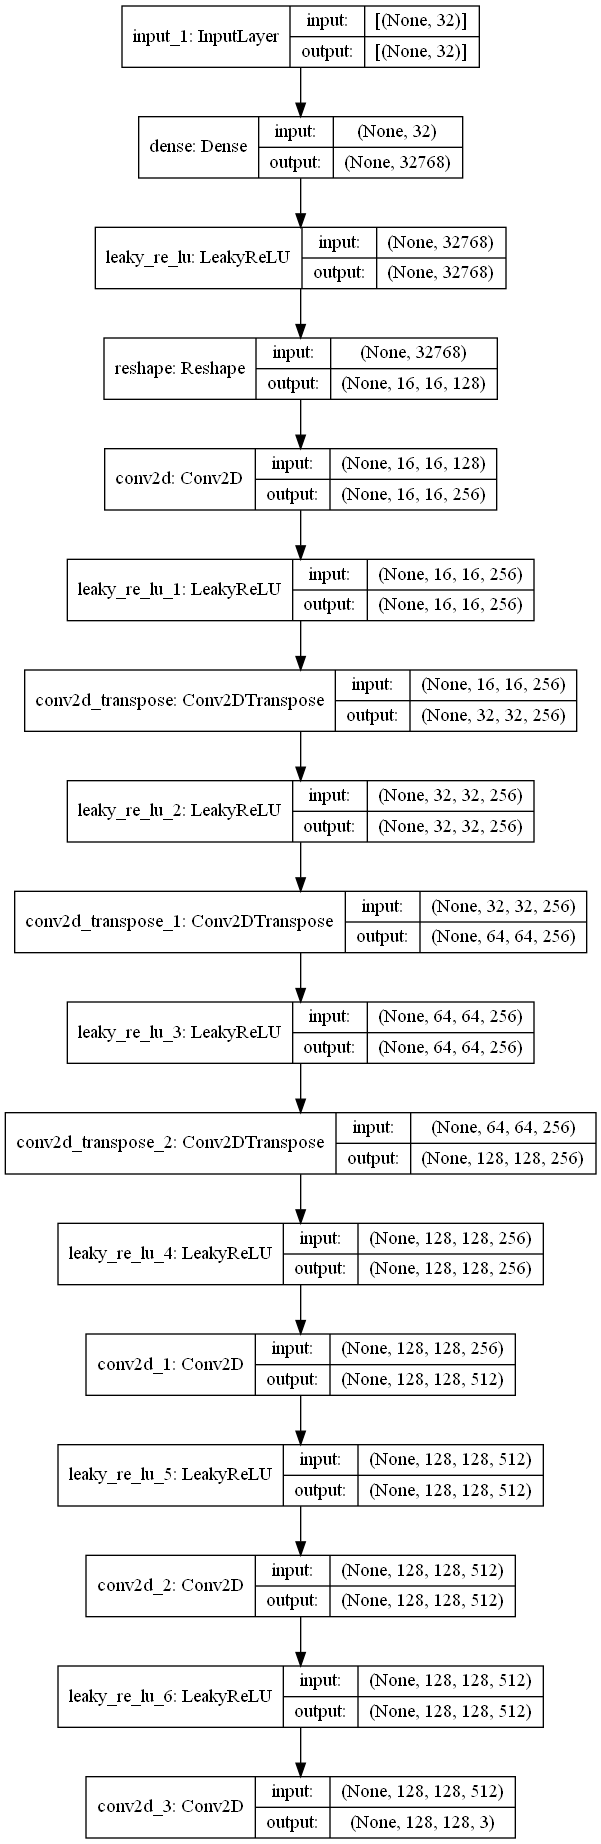

In [9]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [10]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 30, 30, 256)       0   

C:\Users\DannyPC\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


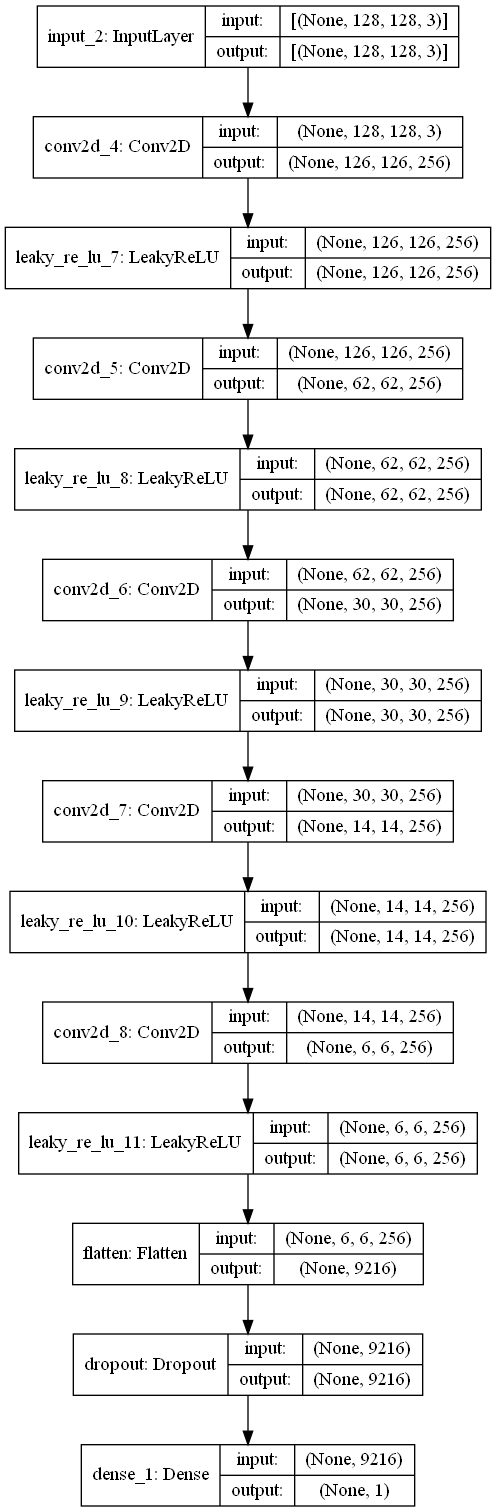

In [11]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

**Combining the GAN Components**

Next, I define the GAN model that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only affects when training the combined GAN model, not when training the discriminator standalone.

I found that RMSProp as an optimizer generates more realistic fake images compared to Adam for this case. The learning rate is 0.0001. Weight decay and clip value stabilize learning during the latter part of the training. Note that you have to adjust the decay if you want to adjust the learning rate.

In [12]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [13]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [14]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_1 (Functional)         (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


**Training the GAN Model**

This section was the most difficult to implement since GANs contain two networks that need to be trained against each other. From past experiments and searching online I noticed that as the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. 

Regarding the convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time and If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its quality may start to deteriorate. 



In [15]:
#Training the GAN Model
import time
iters = 1500
batch_size = 16

# specify file path to store generated images
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):
    start_time = time.time()
    
    # use random noise vectors to generate image data
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    # calculate discriminant loss and append to list of loss values
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    # calculate adversary loss and append to list of loss values
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    # after every 50 iterations, save 'real classified' images and weights
    if step % 50 == 49:
        # save weights from training in dot file
        gan.save_weights('gan.h5')
        
        # print training progress 
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        # format images in 6x6 grid for final output
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        
        # save generated images in folder    
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

50/1500: d_loss: 0.6774,  a_loss: 0.6590.  (41.6 sec)
100/1500: d_loss: 0.6589,  a_loss: 0.6780.  (41.4 sec)
150/1500: d_loss: 0.6869,  a_loss: 0.9338.  (42.7 sec)
200/1500: d_loss: 0.6434,  a_loss: 0.8406.  (42.3 sec)
250/1500: d_loss: 0.5953,  a_loss: 1.0382.  (42.1 sec)
300/1500: d_loss: 0.6582,  a_loss: 0.8884.  (44.1 sec)
350/1500: d_loss: 0.6604,  a_loss: 1.0011.  (42.2 sec)
400/1500: d_loss: 0.6183,  a_loss: 1.5461.  (42.2 sec)
450/1500: d_loss: 0.6538,  a_loss: 0.9773.  (41.4 sec)
500/1500: d_loss: 0.6288,  a_loss: 1.0140.  (45.1 sec)
550/1500: d_loss: 0.7196,  a_loss: 0.9085.  (41.4 sec)
600/1500: d_loss: 0.6124,  a_loss: 1.1714.  (41.2 sec)
650/1500: d_loss: 0.6562,  a_loss: 0.9481.  (41.1 sec)
700/1500: d_loss: 0.6427,  a_loss: 0.8060.  (41.3 sec)
750/1500: d_loss: 0.6869,  a_loss: 0.9502.  (41.3 sec)
800/1500: d_loss: 0.6205,  a_loss: 0.8053.  (41.5 sec)
850/1500: d_loss: 0.7459,  a_loss: 0.9222.  (41.8 sec)
900/1500: d_loss: 0.6880,  a_loss: 0.8245.  (43.7 sec)
950/1500: d

**Discriminator and Generator Loss**

There are not many methods to reliably see the accuracy of the trained model. One common method is observing the quality of the output images and judging based on visual inspection. Other methods involve examining the loss plots for discriminant and generator loss. 

From examining both plots, we can see that all losses are somewhat erratic early in the run before stabilizing around epoch 150 to epoch 300. Losses remain stable after that, although the variance increases.

The time scales (e.g. number of iterations or training epochs) for these patterns and absolute values will vary across problems and types of GAN models, although the plot provides a good baseline for what to expect when training a stable GAN model.


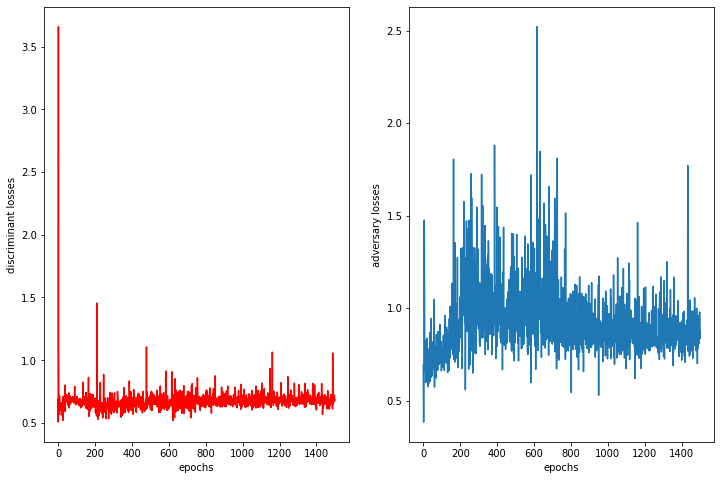

In [16]:
# display discriminant and adversary loss for each epoch/iteration
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

**Generated Images**

The training process was organized so that a valid generated image that was classified as real by the discriminator would be saved to a folder after every 50 iterations. In the most successful experiment, I trained the networks for 1500 iterations meaning by the end, there were 30 images. The output below shows the 8 generated images which I thought conveyed the progress of improvement as the generator and discriminator got better at fooling each other.

By the 21st generated image (6th image below), we can start to see more defined facial features like the nose, eyes, mouth, etc. and from the last image, we can start to see the whites of the eyes. From seeing the results so far, I’d conclude that training the model for an additional 1000 to 2000 iterations would certainly yield more subtle features like wrinkles and skin pores but of course, the images would have to be sampled at higher resolutions.


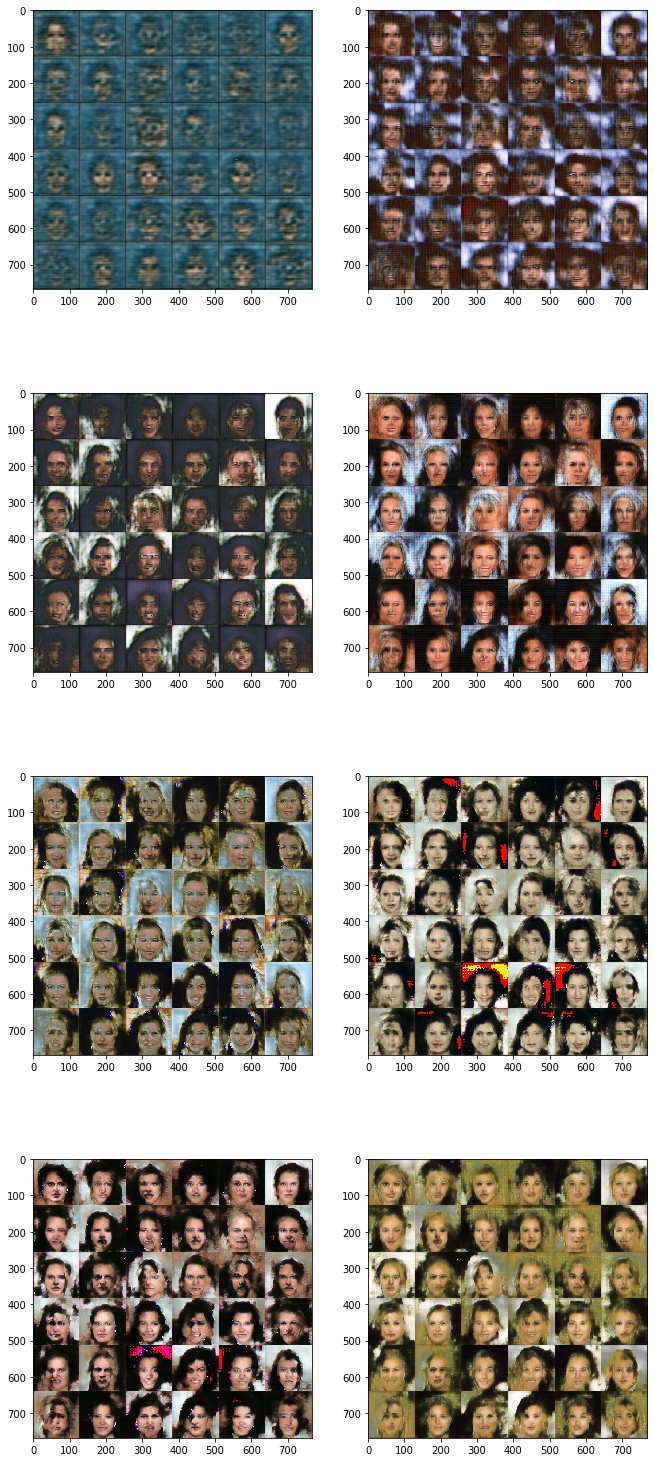

In [2]:
# show example generated images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 11,27

# read images
img_A = mpimg.imread('gen_images_iter1500_backup\generated_1.png')
img_B = mpimg.imread('gen_images_iter1500_backup\generated_5.png')
img_C = mpimg.imread('gen_images_iter1500_backup\generated_9.png')
img_D = mpimg.imread('gen_images_iter1500_backup\generated_13.png')
img_E = mpimg.imread('gen_images_iter1500_backup\generated_17.png')
img_F = mpimg.imread('gen_images_iter1500_backup\generated_21.png')
img_G = mpimg.imread('gen_images_iter1500_backup\generated_25.png')
img_H = mpimg.imread('gen_images_iter1500_backup\generated_29.png')

# display images
fig, ax = plt.subplots(4,2)
ax[0,0].imshow(img_A);
ax[0,1].imshow(img_B);
ax[1,0].imshow(img_C);
ax[1,1].imshow(img_D);
ax[2,0].imshow(img_E);
ax[2,1].imshow(img_F);
ax[3,0].imshow(img_G);
ax[3,1].imshow(img_H);

In [17]:
# compile all output images into a GIF
# WARNING: deletes generated output images from folder, gotta fix it!
import imageio
import shutil 
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('training_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

**Analysis of Results**

While the output images don’t look exactly like the images from the celebrity dataset, the discriminator was getting better at identifying images with more pronounced facial features. It’s also worth noting that the background colors in the generated images remained mostly monochromatic indicating that the backgrounds was seen as a ‘secondary’ priority for the generator when finding patterns in the training set. A possible reason could be due to the dataset images having fewer consistent elements/features present in the background to generate any meaningful content.

Processing 1500 iterations and calculating the discriminant and generator loss after each one proved to be taxing on my computer. Training the network took almost 19 hours but I believe using cloud based platforms like Kaggle or Google Colab would have significantly shortened the training time. Unfortunately, I had some problems getting Google Colab to work. 

Overall, the GAN model successfully identified the facial features needed to generate close-to-real images. Furthermore, as seen from the generated images above, the generator network was able to progressively improve the quality of generated images and the discriminator network was able to improve its ability to distinguish between fake and real images.


**References**

How to Identify and Diagnose GAN Failure Modes<br>
https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

Understanding GAN Loss Functions<br>
https://neptune.ai/blog/gan-loss-functions

A Beginner's Guide to Generative Adversarial Networks (GANs)<br>
https://wiki.pathmind.com/generative-adversarial-network-gan

Generative Adversarial Networks By Ian J. Goodfellow et all.<br>
https://arxiv.org/abs/1406.2661



